# About this notebook  

TBD...


# Directory settings

In [1]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = "./"
MODEL_DIR = "../input/cassava-model/"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images"
TEST_PATH = "../input/cassava-leaf-disease-merged/train"
# TEST_PATH = "../input/cassava-leaf-disease-classification/train_images"
# TEST_PATH = "../input/cassava-leaf-disease-classification/test_images"

# CFG

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug = False
    num_workers = 4
    models = [
        # "tf_efficientnet_b3_ns",
        "tf_efficientnet_b4_ns",
        "vit_base_patch16_384",
        # "deit_base_patch16_384",
        "seresnext50_32x4d",
    ]
    size = {
        "tf_efficientnet_b3_ns": 512,
        "tf_efficientnet_b4_ns": 512,
        "vit_base_patch16_384": 384,
        "deit_base_patch16_384": 384,
        "seresnext50_32x4d": 512,
    }
    batch_size = 64
    seed = 22
    target_size = 5
    target_col = "label"
    n_fold = 5
    trn_fold = {  # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        "tf_efficientnet_b3_ns": {
            "best": [0, 1, 2, 3, 4],
            "final": [],
        },
        "tf_efficientnet_b4_ns": {
            "best": [0, 1, 2, 3, 4],
            "final": [],
        },
        "vit_base_patch16_384": {"best": [0, 1, 2, 3, 4], "final": []},
        "deit_base_patch16_384": {"best": [0, 1, 2, 3, 4], "final": []},
        "seresnext50_32x4d": {"best": [5, 6, 7, 8, 9], "final": []},
    }
    data_parallel = {
        "tf_efficientnet_b3_ns": False,
        "tf_efficientnet_b4_ns": True,
        "vit_base_patch16_384": False,
        "deit_base_patch16_384": False,
        "seresnext50_32x4d": False,
    }
    weight = {
        # "tf_efficientnet_b3_ns": None,
        "tf_efficientnet_b4_ns": 1,
        "vit_base_patch16_384": 1,
        # "deit_base_patch16_384": None,
        "seresnext50_32x4d": 1,
    }
    tta = 3  # 1: no TTA, >1: TTA
    train = False
    inference = True

In [3]:
weight_sum = sum([CFG.weight[model] for model in CFG.models]) * CFG.tta

# Library

In [4]:
# ====================================================
# Library
# ====================================================
import sys

sys.path.append("../input/pytorch-image-models/pytorch-image-models-master")

import math
import os
import random
import shutil
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from albumentations import (
    CenterCrop,
    CoarseDropout,
    Compose,
    Cutout,
    HorizontalFlip,
    HueSaturationValue,
    IAAAdditiveGaussianNoise,
    ImageOnlyTransform,
    Normalize,
    OneOf,
    RandomBrightness,
    RandomBrightnessContrast,
    RandomContrast,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    ShiftScaleRotate,
    Transpose,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [5]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "inference.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

# Data Loading

In [6]:
# test = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
# test = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
test = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")
test.head()

,image_id,label,source
0,1000015157.jpg,0,2020
1,1000201771.jpg,3,2020
2,100042118.jpg,1,2020
3,1000723321.jpg,1,2020
4,1000812911.jpg,3,2020


# Dataset

In [7]:
# ====================================================
# Dataset
# ====================================================
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TEST_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

# Transforms

In [8]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data, size):

    if data == "train":
        return Compose(
            [
                # Resize(size, size),
                RandomResizedCrop(size, size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                CoarseDropout(p=0.5),
                Cutout(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    if data == "valid":
        return Compose(
            [
                Resize(size, size),
                CenterCrop(size, size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    if data == "inference":
        return Compose(
            [
                # Resize(size, size),
                RandomResizedCrop(size, size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                # ShiftScaleRotate(p=0.5),
                # HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                # RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                # CoarseDropout(p=0.5),
                # Cutout(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

# MODEL

In [9]:
# ====================================================
# MODEL
# ====================================================
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()

        if model_name == "deit_base_patch16_384":
            # self.model = torch.hub.load("facebookresearch/deit:main", model_name, pretrained=pretrained)
            self.model = torch.hub.load("../input/fair-deit", model_name, pretrained=pretrained, source="local")
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, CFG.target_size)

        else:
            self.model = timm.create_model(model_name, pretrained=pretrained)

            if "resnext50_32x4d" in model_name:
                n_features = self.model.fc.in_features
                self.model.fc = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("tf_efficientnet"):
                n_features = self.model.classifier.in_features
                self.model.classifier = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("vit_"):
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

# Helper functions

In [10]:
# ====================================================
# Helper functions
# ====================================================
def inference(model, states, test_loader, device, data_parallel):
    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and data_parallel:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state["model"])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# inference

In [11]:
# ====================================================
# inference
# ====================================================
predictions = None
for model_name in CFG.models:
    for i in range(CFG.tta):
        model = CassvaImgClassifier(model_name, pretrained=False)
        states = []
        for saved_model in ["best", "final"]:
            if CFG.trn_fold[model_name][saved_model] != []:
                LOGGER.info(
                    f"========== Model: {model_name}, TTA: {i}, Saved: {saved_model}, Fold: {CFG.trn_fold[model_name][saved_model]} =========="
                )
                states += [
                    torch.load(MODEL_DIR + f"{model_name}_fold{fold}_{saved_model}.pth")
                    for fold in CFG.trn_fold[model_name][saved_model]
                ]

        if i == 0:  # no TTA
            test_dataset = TestDataset(test, transform=get_transforms(data="valid", size=CFG.size[model_name]))
        else:
            test_dataset = TestDataset(test, transform=get_transforms(data="inference", size=CFG.size[model_name]))

        test_loader = DataLoader(
            test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True
        )

        inf = inference(model, states, test_loader, device, CFG.data_parallel[model_name])

        LOGGER.info(f"Inference example: {inf[0]}")

        if predictions is None:
            predictions = inf[np.newaxis] * CFG.weight[model_name]
        else:
            predictions = np.append(predictions, inf[np.newaxis] * CFG.weight[model_name], axis=0)

sub = np.sum(predictions, axis=0) / weight_sum
LOGGER.info(f"========== Overall ==========")
LOGGER.info(f"Submission example: {sub[0]}")
np.savetxt(f"{OUTPUT_DIR}/predictions.csv", sub, delimiter=",")

# submission
test["label"] = sub.argmax(1)
test[["image_id", "label"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)
test.head()

========== Model: tf_efficientnet_b4_ns, TTA: 0, Saved: best, Fold: [0, 1, 2, 3, 4] ==========


  0%|          | 0/412 [00:00<?, ?it/s]

Inference example: [0.4113303  0.16465071 0.19031808 0.01710353 0.21659732]
========== Model: tf_efficientnet_b4_ns, TTA: 1, Saved: best, Fold: [0, 1, 2, 3, 4] ==========


  0%|          | 0/412 [00:00<?, ?it/s]

Inference example: [0.48532075 0.15037784 0.23644516 0.02698353 0.10087272]
========== Model: tf_efficientnet_b4_ns, TTA: 2, Saved: best, Fold: [0, 1, 2, 3, 4] ==========


  0%|          | 0/412 [00:00<?, ?it/s]

Inference example: [0.3294753  0.21423021 0.29620296 0.02863643 0.1314551 ]
========== Model: vit_base_patch16_384, TTA: 0, Saved: best, Fold: [0, 1, 2, 3, 4] ==========


  0%|          | 0/412 [00:00<?, ?it/s]

Inference example: [0.44151726 0.12938017 0.24077013 0.04045077 0.14788169]
========== Model: vit_base_patch16_384, TTA: 1, Saved: best, Fold: [0, 1, 2, 3, 4] ==========


  0%|          | 0/412 [00:00<?, ?it/s]

Inference example: [0.42230922 0.08196902 0.32993802 0.05142972 0.11435406]
========== Model: vit_base_patch16_384, TTA: 2, Saved: best, Fold: [0, 1, 2, 3, 4] ==========


  0%|          | 0/412 [00:00<?, ?it/s]

Inference example: [0.32653087 0.31568345 0.15996166 0.05122393 0.14660004]
========== Model: seresnext50_32x4d, TTA: 0, Saved: best, Fold: [5, 6, 7, 8, 9] ==========


  0%|          | 0/412 [00:00<?, ?it/s]

Inference example: [0.2990355  0.3897496  0.09844354 0.02557188 0.1871995 ]
========== Model: seresnext50_32x4d, TTA: 1, Saved: best, Fold: [5, 6, 7, 8, 9] ==========


  0%|          | 0/412 [00:00<?, ?it/s]

Inference example: [0.26858085 0.20290053 0.23426536 0.03780187 0.2564514 ]
========== Model: seresnext50_32x4d, TTA: 2, Saved: best, Fold: [5, 6, 7, 8, 9] ==========


  0%|          | 0/412 [00:00<?, ?it/s]

Inference example: [0.2038373  0.23594086 0.16766731 0.07201287 0.32054168]
========== Overall ==========
Submission example: [0.35421526 0.20943135 0.21711247 0.03902384 0.18021706]


,image_id,label,source
0,1000015157.jpg,0,2020
1,1000201771.jpg,3,2020
2,100042118.jpg,4,2020
3,1000723321.jpg,1,2020
4,1000812911.jpg,3,2020


# Validation

In [12]:
# train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
train = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")

In [13]:
cm = confusion_matrix(train["label"], test["label"])
cm = cm / cm.astype(np.float).sum(axis=1)

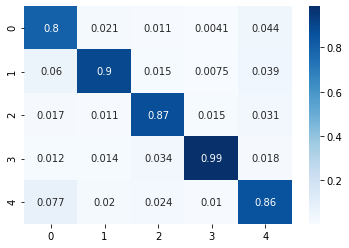

In [14]:
sns.heatmap(cm, annot=True, cmap="Blues")
plt.savefig(f"images/{model_name}.png")

In [15]:
print(classification_report(train["label"], test["label"]))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1492
           1       0.93      0.90      0.91      3476
           2       0.91      0.87      0.89      3017
           3       0.96      0.99      0.97     15462
           4       0.87      0.86      0.86      2890

    accuracy                           0.94     26337
   macro avg       0.90      0.88      0.89     26337
weighted avg       0.94      0.94      0.94     26337



In [16]:
print(get_score(train["label"], test["label"]))

0.9362114136006379
